In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions



In [ ]:
pip install sumy

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import PorterStemmer
nltk.download('punkt')
import contractions
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
db=pd.read_csv("/content/drive/MyDrive/Text_Mining_Project_Amazon/Reviews.csv")

In [ ]:
subset = {"UserId", "Time", "Text"}
db = db.drop_duplicates(subset=subset, keep="first")

In [ ]:
db.shape

(393892, 10)

In [ ]:
db.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Preprocessing

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
def clean_text_ale(document):
  document = contractions.fix(document) 
  document = re.sub("<br>", "", document)

  document = re.sub("[£$€₽¥]+", "money", document)
  document = remove_emoji(document)
  document = re.sub('[-_()*/\|<>^°#@=%"&]+', "", document)
  return document

  

In [ ]:
db['Text'] = db['Text'].apply(clean_text_ale)


In [ ]:
db.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## SUMY (LSA)

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer

In [ ]:
def sumy_lsa(text,numofsentences):
  parser = PlaintextParser.from_string(text,Tokenizer("english"))
  # Using LexRank
  summarizer = LsaSummarizer()
  #Summarize the document with 1 sentences
  summary = summarizer(parser.document,numofsentences) 
  for sentence in summary:
    return str(sentence)

In [ ]:
#Example with one review
print("Review:","\n",db['Text'][0])
print()
print("Original summary:","\n",db['Summary'][0])
print()
print("Predicted summary:" )
sumy_lsa(db['Text'][0],1)

Review: 
 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Original summary: 
 Good Quality Dog Food

Predicted summary:


'My Labrador is finicky and she appreciates this product better than  most.'

## SUMY (TextRank)

In [ ]:
from sumy.summarizers.text_rank import TextRankSummarizer

In [ ]:
def sumy_textrank(text,numofsentences):
  parser = PlaintextParser.from_string(text,Tokenizer("english"))
  summarizer = TextRankSummarizer()
  summary = summarizer(parser.document,numofsentences) 
  for sentence in summary:
    return str(sentence)

In [ ]:

print("Review:","\n",db['Text'][7])
print()
print("Original summary:","\n",db['Summary'][7])
print()
print("Predicted summary:" )
sumy_textrank(db['Text'][7],1)

Review: 
 This taffy is so good.  It is very soft and chewy.  The flavors are amazing.  I would definitely recommend you buying it.  Very satisfying!!

Original summary: 
 Wonderful, tasty taffy

Predicted summary:


'It is very soft and chewy.'

## Bert

In [ ]:
#Install requirements and BERT summarizer
!pip install spacy
!pip install transformers  
!pip install bert-extractive-summarizer

In [ ]:
#Import BERT Summarizer 
from summarizer import Summarizer,TransformerSummarizer

In [ ]:
bert_model = Summarizer()

In [ ]:
def Bert_summarizer(text):
  outp= bert_model(text)
  bert_summary = ''.join(outp)
  s = sent_tokenize(bert_summary)
  return str(s[0])

In [ ]:
print("Review:","\n",db['Text'][7])
print()
print("Original summary:","\n",db['Summary'][7])
print()
print("Predicted summary:","\n",Bert_summarizer(db['Text'][7]))

Review: 
 This taffy is so good.  It is very soft and chewy.  The flavors are amazing.  I would definitely recommend you buying it.  Very satisfying!!

Original summary: 
 Wonderful, tasty taffy

Predicted summary: 
 I would definitely recommend you buying it.


# Evaluation

In [ ]:
def count_text(txt):
  words = txt.split()
  out=len(words)
  return int(out)


In [ ]:
db["num_word"]=db["Text"].apply(count_text)

In [ ]:
db.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,num_word
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,92
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,41
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,27


In [ ]:
db_test = db.loc[(db["num_word"]>75) & (db["num_word"]<150)].sample(n=20,random_state=15)

In [ ]:
db_test

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,num_word
418756,418757,B001E5E006,A2I2KWNVZDHD4F,Doing My Research,16,24,1,1174003200,Not a good Amazon purchase...,Two of the six packages were beginning to mold...,94
104666,104667,B0002F7MX6,A2TRJU6Y5J9B1S,Trish's Old List,7,7,5,1325462400,The Original Acetum Balsami Glaze - BLAZE,"This is a superbly delicious, sweet and tangy ...",92
244573,244574,B000Y4146G,A277ERJUOBNROA,"Jude ""lit hag""",0,0,2,1332028800,Not For My Dog,I have a Lhasa Apso puppy that weighs 6 pounds...,89
56161,56162,B0016LL5DS,A39Y59C6FTC0GL,Christine,4,4,4,1304467200,"Like it, but not as much as Nutella",I bought this for three reasons:br br 1.Organi...,145
406683,406684,B000E63LDS,A3M2WFOCSWKC0Q,Kalavan,1,1,5,1328832000,Favorite!,This is my wife's FAVORITE tea! We live in Swi...,86
272781,272782,B000IEHQV4,A1M3LM4NJ8IWT9,"M. Light ""Amazon Junkie""",0,1,1,1324684800,"VERY flimsy containers, arrived all smashed up",I ordered one of these cases packages of six t...,98
76081,76082,B001O2F5VC,A3GTV5KHN00MMW,W. Keller,0,0,5,1301875200,Yummo,To be honest I do not know why these are so ha...,88
234386,234387,B000F4H5GI,A29L15GKGGA3UO,"Thomas MacEntee ""Genealogy Ninja and GeneaBlo...",0,0,5,1202428800,Brings Me Back Home,to my greatgrandmother's house in upstate New ...,96
21429,21430,B002QWP89S,AXPS51YI6WQRG,surfergal,0,0,5,1287187200,My pugs favorite dental treat & works!,I have had my pug Koa for over 6 years now. Si...,92
71985,71986,B001SAQA8W,A25SZPSN9QHN1K,rick,0,0,5,1349049600,Lysander's Beef Meat Rub,I was introduced to Lysander's products a coup...,80


In [ ]:
db_test.shape

(20, 11)

In [ ]:
db_test = db_test.reset_index()

In [ ]:
db_test = db_test.drop(['Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time',"ProductId","index","num_word"], 1)


In [ ]:
db_test

,Summary,Text
0,Not a good Amazon purchase...,Two of the six packages were beginning to mold...
1,The Original Acetum Balsami Glaze - BLAZE,"This is a superbly delicious, sweet and tangy ..."
2,Not For My Dog,I have a Lhasa Apso puppy that weighs 6 pounds...
3,"Like it, but not as much as Nutella",I bought this for three reasons:br br 1.Organi...
4,Favorite!,This is my wife's FAVORITE tea! We live in Swi...
5,"VERY flimsy containers, arrived all smashed up",I ordered one of these cases packages of six t...
6,Yummo,To be honest I do not know why these are so ha...
7,Brings Me Back Home,to my greatgrandmother's house in upstate New ...
8,My pugs favorite dental treat & works!,I have had my pug Koa for over 6 years now. Si...
9,Lysander's Beef Meat Rub,I was introduced to Lysander's products a coup...


In [ ]:
LSA = [sumy_lsa(db_test['Text'][i],1) for i in range(20)]
TextRank = [sumy_textrank(db_test['Text'][i],1) for i in range(20)]
BERT = [Bert_summarizer(db_test['Text'][i]) for i in range(20)]


In [ ]:
allmodel=[LSA,TextRank,BERT]

In [ ]:
evaluation = pd.DataFrame(pd.concat([pd.DataFrame([i for i in allmodel])]))


In [ ]:
evaluation = db_test.transpose().append(evaluation)
evaluation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Summary,Not a good Amazon purchase...,The Original Acetum Balsami Glaze - BLAZE,Not For My Dog,"Like it, but not as much as Nutella",Favorite!,"VERY flimsy containers, arrived all smashed up",Yummo,Brings Me Back Home,My pugs favorite dental treat & works!,Lysander's Beef Meat Rub,"McCormick Fajitas Marinade & Seasoning, 30-Ounce",Not bad for a buck!,Poor customer service,Alfredo sauce at it's finest,Needs Vitamin D,The luxury of a pumpkin spice latte without th...,The very best lemon tea!,Where's the chocolate filling?,"Rich, Healthy and Delicious","Flavorful, Creamy & Smooth Split Pea Soup"
Text,Two of the six packages were beginning to mold...,"This is a superbly delicious, sweet and tangy ...",I have a Lhasa Apso puppy that weighs 6 pounds...,I bought this for three reasons:br br 1.Organi...,This is my wife's FAVORITE tea! We live in Swi...,I ordered one of these cases packages of six t...,To be honest I do not know why these are so ha...,to my greatgrandmother's house in upstate New ...,I have had my pug Koa for over 6 years now. Si...,I was introduced to Lysander's products a coup...,I purchased this seasoning thinking it was the...,I expected three herring derrieres and I got f...,I have used this product for several years. W...,I have an adult foster home and always look fo...,"I am slightly vitamin D deficient, and my doct...",I sampled Green Mountain's pumpkin spice coffe...,This lemonflavored herbal tea surpasses all si...,Please do not purchase this cereal if you expe...,This Rishi tea is a good stepping stone from s...,If you struggled for years using store bought ...
0,I was curious to see if any of the packs were ...,I use it on all kinds of salads in conjunction...,I am sorry I did not do the research beforehan...,"Sometimes, an organic product will taste diffe...","We live in Switzerland, but import about 50yes...","In any event, it was a disappointment that non...",But they are made of pretty good stuff and is ...,I cannot even get the price lower than this he...,I have pretty much invested a lot of money for...,I was introduced to Lysander's products a coup...,Unfortunately it is not even close to being th...,It looked like one of the more pricey brands!,I am very disappointed in the seller and will ...,"Nowthis sauce mix is so easy to make, you add ...",I emailed the company that makes it and asked ...,So now I get the luxury of a pumpkin spice lat...,My favorite products always have a habit of be...,Finally I realized that there was indeed an in...,I have read recently that this type of tea wit...,If you struggled for years using store bought ...
1,I was curious to see if any of the packs were ...,"Blaze offers other flavors such as fig, chocol...",I am sorry I did not do the research beforehan...,I bought this for three reasons:br br 1.Organi...,"We live in Switzerland, but import about 50yes...",The external box was not mangled I have to be...,"Sure, sometimes the pieces look plain creepy b...","Tea, and good strong tea, is served at lunchdi...",I have pretty much invested a lot of money for...,"As a result, I use the beef rub or the pork ru...",If you like the way the mix tastes that comes ...,"Also, mine were from Canada, not Poland.br br ...","Since each of the bottles is 28 ounces, I do n...",You do have to condense the amounts made it ta...,I emailed the company that makes it and asked ...,"I love that, and if you love clove too I think...",We used to be able to get it in any grocery st...,"I guess the taste is not that bad overall, but...",It has a full flavor profile and the ginger ad...,For years I tried different recipes and was ne...
2,Two of the six packages were beginning to mold...,"This is a superbly delicious, sweet and tangy ...",I have a Lhasa Apso puppy that weighs 6 pounds...,I bought this for three reasons:br br 1.Organi...,"We live in Switzerland, but import about 50yes...",I ordered one of these cases packages of six t...,To be hone

In [ ]:
evaluation.to_csv("/content/drive/MyDrive/Text_Mining_Project_Amazon/CodiceAle/doevaluationonthis.csv")

In [ ]:
score=pd.read_excel("/content/drive/MyDrive/Text_Mining_Project_Amazon/CodiceAle/modelscores.xlsx")
score = score.drop(["Unnamed: 0"], 1)

In [ ]:
score.head()

,LSA,TextRank,BERT
0,1,1,3
1,1,2,3
2,2,2,1
3,3,2,2
4,1,1,1


In [ ]:
from statistics import mean, stdev
LSA_av = mean(score.LSA)
LSA_sd = stdev(score.LSA)

TextRank_av = mean(score.TextRank)
TextRank_sd = stdev(score.TextRank)


BERT_av = mean(score.BERT)
BERT_sd = stdev(score.BERT)

means = {"LSA":LSA_av,"TextRank":TextRank_av,"BERT":BERT_av}
sds = {"LSA":LSA_sd,"TextRank":TextRank_sd,"BERT":BERT_sd}

In [ ]:
res = pd.concat([pd.DataFrame(means.values(),index=means.keys(),columns=['Average']),pd.DataFrame(sds.values(),index=means.keys(),columns=['SD'])],axis=1).sort_values('Average',ascending=False)
res

,Average,SD
TextRank,2.2,0.833509
LSA,1.9,0.788069
BERT,1.7,0.732695


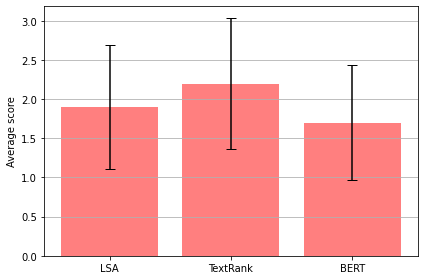

In [ ]:
x = means.keys()
y = means.values()
fig, ax = plt.subplots()
ax.bar(x, y, yerr=sds.values(), align='center', alpha=0.5,color="red", ecolor='black', capsize=5)
ax.set_ylabel('Average score')
ax.yaxis.grid(True)
# Save the figure and show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Text_Mining_Project_Amazon/CodiceAle/val.png')
plt.show()